In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

### train 总共31788324个数据，customer 1371980，articles 105542, submit 1371980
### train 里不同customer_id 1362281, 接近10000的customer_id 没有出现
### train 里不同activle_id 104547
### train 里不同顾客在不同日期购买不同商品 数量28575395

In [2]:
train = pd.read_csv('data/transactions_train.csv')
articles=pd.read_csv('data/articles.csv')
customers=pd.read_csv('data/customers.csv')

In [3]:
train['customer_id'] =train['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
customers['customer_id'] =customers['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
train['article_id'] = train['article_id'].astype('int32')
articles['article_id'] = articles['article_id'].astype('int32')

In [4]:
train.t_dat = pd.to_datetime( train.t_dat )
train['year'] = (train.t_dat.dt.year-2000).astype('int8')
train['month'] = (train.t_dat.dt.month).astype('int8')
train['day'] = (train.t_dat.dt.day).astype('int8')

In [5]:
submit=pd.read_csv('data/sample_submission.csv')
submit['customer_id']=submit['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [6]:
def plot_out(df,x):
    sns.set_style("darkgrid")
    f, ax = plt.subplots(figsize=(10,5))
    ax = sns.boxplot(data=df, x=x, color='orange')
    ax.set_xlabel('outliers')
    plt.show()

In [7]:
def look_at_customer(customer_id):
    print('customer_id is ', customer_id)
    print('his purchase num is', len(train[train['customer_id']==customer_id]['customer_id']))
    print('his purchase day num is', train[train['customer_id']==customer_id].t_dat.nunique())
    print('his purchase article num is',train[train['customer_id']==customer_id].article_id.nunique())

In [8]:
## 添加article最早上市时间
article_time_df=train[['t_dat','article_id']].groupby('article_id').min().reset_index().rename(columns={'t_dat':'article_launch_time'}).sort_values('article_launch_time', ascending=False)
articles=articles.merge(article_time_df,how='left',on=['article_id'])
del article_time_df
articles=articles[~np.isnan(articles['article_launch_time'])]

In [9]:
## 添加article上市时间特征
articles['article_launch_year'] = (articles.article_launch_time.dt.year-2000).astype('int8')
articles['article_launch_month'] = (articles.article_launch_time.dt.month).astype('int8')
articles['article_launch_day'] = (articles.article_launch_time.dt.day).astype('int8')
articles['article_launch_bin']=articles['article_launch_month'].apply(lambda x:x//3.5).astype('int8')
del articles['article_launch_time']

In [10]:
## 添加顾客最早购买时间
customer_time_df=train[['t_dat','customer_id']].groupby('customer_id').min().reset_index().rename(columns={'t_dat':'customer_launch_time'})
customers=customers.merge(customer_time_df,how='left',on=['customer_id'])
del customer_time_df
customers=customers[~np.isnan(customers['customer_launch_time'])]
customers['customer_launch_year'] = (customers.customer_launch_time.dt.year-2000).astype('int8')
customers['customer_launch_month'] = (customers.customer_launch_time.dt.month).astype('int8')
customers['customer_launch_day'] = (customers.customer_launch_time.dt.day).astype('int8')

In [11]:
## 添加顾客 总购买数^，购买天数^，购买种类数^，
## 平均购买间隔，最高购买间隔，
## 总购买数^，平均天购买数^，平均种类购买件数^，最高种类购买数，最高天购买数，
## 总购买金额^，平均天购买金额^,平均种类购买金额^,最高种类购买金额=max(种类购买金额），最高天购买金额=max(天购买金额）
agg_dict={'t_dat':['count', 'nunique', 'max'], 'article_id':['nunique'],'price':['sum','mean','max','min','median','std']}
customer_df=train[['customer_id','t_dat','article_id','price']].groupby('customer_id').agg(agg_dict).reset_index()
customer_df.columns=['customer_id','total_purchase_num',
                     'total_purchase_day_num','recent_purchase_day',
                     'purchase_unique_article_num',
                     'total_cost','mean_cost','max_unit_cost','min_unit_cost','median_unit_cost','std_unit_cost']
customer_df['avg_article_purchase_num']=customer_df['total_purchase_num']/customer_df['purchase_unique_article_num']
customer_df['avg_day_purchase_num']=customer_df['total_purchase_num']/customer_df['total_purchase_day_num']
customer_df['avg_day_cost']=customer_df['total_cost']/customer_df['total_purchase_day_num']
customer_df['avg_article_cost']=customer_df['total_cost']/customer_df['purchase_unique_article_num']

In [12]:
customer_day_cnt_df=train.groupby(['customer_id','t_dat'])['price'].count().reset_index().rename(columns={'price':'customer_day_cnt'}).groupby('customer_id')['customer_day_cnt'].max().reset_index().rename(columns={'customer_day_cnt':'customer_max_day_cnt'})
customer_day_cost_df=train.groupby(['customer_id','t_dat'])['price'].sum().reset_index().rename(columns={'price':'customer_day_cost'}).groupby('customer_id')['customer_day_cost'].max().reset_index().rename(columns={'customer_day_cost':'customer_max_day_cost'})
customer_article_cnt_df=train.groupby(['customer_id','article_id'])['price'].count().reset_index().rename(columns={'price':'customer_article_cnt'}).groupby('customer_id')['customer_article_cnt'].max().reset_index().rename(columns={'customer_article_cnt':'customer_max_article_cnt'})
customer_article_cost_df=train.groupby(['customer_id','article_id'])['price'].sum().reset_index().rename(columns={'price':'customer_article_cost'}).groupby('customer_id')['customer_article_cost'].max().reset_index().rename(columns={'customer_article_cost':'customer_max_article_cost'})
customer_df=customer_df.merge(customer_day_cnt_df, how='left', on=['customer_id'])
customer_df=customer_df.merge(customer_day_cost_df, how='left', on=['customer_id'])
customer_df=customer_df.merge(customer_article_cnt_df, how='left', on=['customer_id'])
customer_df=customer_df.merge(customer_article_cost_df, how='left', on=['customer_id'])
del customer_day_cnt_df
del customer_day_cost_df
del customer_article_cnt_df
del customer_article_cost_df

In [13]:
customers=customers.merge(customer_df,how='left',on='customer_id')
del customer_df

In [14]:
customers['day_duration']=(customers['recent_purchase_day']-customers['customer_launch_time']).dt.days

In [15]:
day_diff_df=train[['customer_id','t_dat']].drop_duplicates()

In [16]:
def cal_mean_day_diff(dats):
    dats=dats.values
    if len(dats)==1:
        return None
    dats.sort()
    res=[]
    for i in range(1,len(dats)):
        day0,day1=np.datetime64(dats[i-1]),np.datetime64(dats[i])
        diff=(day1-day0)/np.timedelta64(1, 'D')
        res.append(diff)
    return sum(res)/len(res)

def cal_max_day_diff(dats):
    dats=dats.values
    if len(dats)==1:
        return None
    dats.sort()
    res=[]
    for i in range(1,len(dats)):
        day0,day1=np.datetime64(dats[i-1]),np.datetime64(dats[i])
        diff=(day1-day0)/np.timedelta64(1, 'D')
        res.append(diff)
    return max(res)

In [17]:
mean_day_diff_df=day_diff_df.groupby('customer_id').agg(cal_mean_day_diff).reset_index()
max_day_diff_df=day_diff_df.groupby('customer_id').agg(cal_max_day_diff).reset_index()
mean_day_diff_df.columns=["customer_id","mean_purchase_day_diff"]
max_day_diff_df.columns=["customer_id","max_purchase_day_diff"]

In [18]:
customers=customers.merge(mean_day_diff_df, how='left', on=['customer_id'])
customers=customers.merge(max_day_diff_df, how='left', on=['customer_id'])
del mean_day_diff_df
del max_day_diff_df
del day_diff_df

In [19]:
customer_purchase_cluster_features=['total_purchase_num',
                     'total_purchase_day_num',
                     'purchase_unique_article_num',
                     'total_cost','mean_cost','max_unit_cost','min_unit_cost','median_unit_cost','std_unit_cost',
                     'avg_article_purchase_num','avg_day_purchase_num','avg_day_cost','avg_article_cost',
                      "mean_purchase_day_diff","max_purchase_day_diff"]

In [20]:
## 移除总购买数超过300件顾客数据
remove_customers=list(customers[customers['total_purchase_num']>300].customer_id.values)
customers_1=customers[customers['total_purchase_num']<300]
train=train.merge(customers_1['customer_id'],on=['customer_id'])

## 顾客查看

In [21]:
import os
import glob

from tqdm import tqdm
import datetime

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [22]:
from IPython.display import display

def show_image(image,figsize=None,title=None):
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
    
    # if isinstance(image, str):
    #     try:
    #         image = mpimg.imread(f'data/images_128_128/0{str(image)[:2]}/0{int(image)}.jpg')
    #     except:
    #         image = np.zeros([16,16,3])
    image = mpimg.imread(f'data/images_128_128/0{str(image)[:2]}/0{int(image)}.jpg')
    if image.ndim == 2:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image)
            
def show_Nimages_all(imgs,scale=1,titles=None):

    N=len(imgs)
    fig = plt.figure(figsize=(25/scale, 16/scale))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1, N, i + 1, xticks=[], yticks=[])
        show_image(img)
        if titles is not None:
            title = titles[i]
            ax.title.set_text(title)
    plt.show()

def show_Nimages(imgs, num_per_row=10, scale=1, titles=None):

    N=len(imgs)
    current=0
    remaining=N
    while remaining > num_per_row:
        images = imgs[current:current+10]
        
        current_titles = None
        if titles is not None:
            current_titles = titles[current:current+10]
            
        show_Nimages_all(images, scale, current_titles)
        
        remaining -= num_per_row
        try: 
            imgs = imgs[current+10:]
            titles = titles[current+10:]
        except: pass
    
    if len(imgs) > 0:
        show_Nimages_all(imgs, scale, titles)
        
def make_titles(titles, prices):
    new_titles = []
    assert len(titles) == len(prices)
    
    for i in range(len(titles)):
        new_titles.append(f'{str(titles[i])[:10]}:{prices[i]:.2f}')
    return new_titles

def print_customer(data, articles_df, cus_id, repeat_threshold=3):
    cus = cus_id

    cus_df = data.query('customer_id == @cus')
    print(f'\n** Total items bought = {cus_df.shape[0]}**\n')

    titles = cus_df.t_dat.values
    prices = cus_df.price.values
    plt.plot(prices)
    plt.title(f'average price = {prices.mean():.3f}, std = {prices.std():.3f}')
    
#     print('sales_channel_id')
    print(f'channel_id:', cus_df['sales_channel_id'].value_counts(),'\n')
    
    # favorite colors, repeated sales
    article_id_str = cus_df['article_id'].values
    cus_df.loc[:,'article_id'] = cus_df['article_id'].apply(lambda x: int(x))
    cus_df = pd.merge(cus_df, articles_df, how="left", on=["article_id"])
    cus_df.loc[:,'article_id'] = article_id_str
        
#     print(cus_df['perceived_colour_master_name'].value_counts(normalize=True)[:3])
    
    f, ax = plt.subplots(figsize=(10, 6))
    ax = sns.histplot(data=cus_df, y='perceived_colour_master_name', hue='prod_name', multiple="stack")
    ax.set_xlabel('Count by color')
    ax.set_ylabel('Favorite Colors')
    plt.show()
    
    product_repeated_num = cus_df['prod_name'].value_counts(normalize=False)
    if product_repeated_num[0] >= repeat_threshold:
        print('** LOVE buy repeating items **')
        print(product_repeated_num[:3])
    else:
        print('** DONT love buy repeating items **')
    
    titles  = make_titles(titles, prices)
    
    images = cus_df.article_id.values
    show_Nimages(images,titles=titles)



** Total items bought = 18**

channel_id: 2    18
Name: sales_channel_id, dtype: int64 



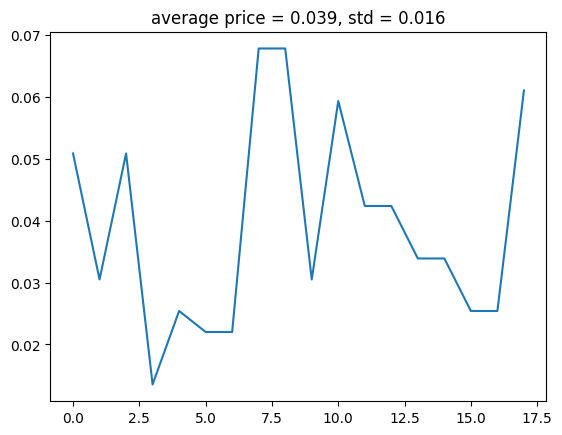

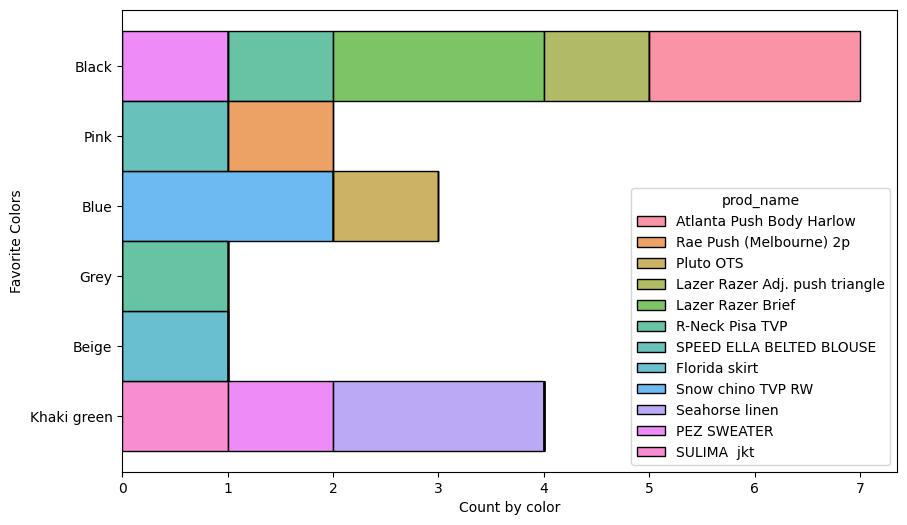

** DONT love buy repeating items **


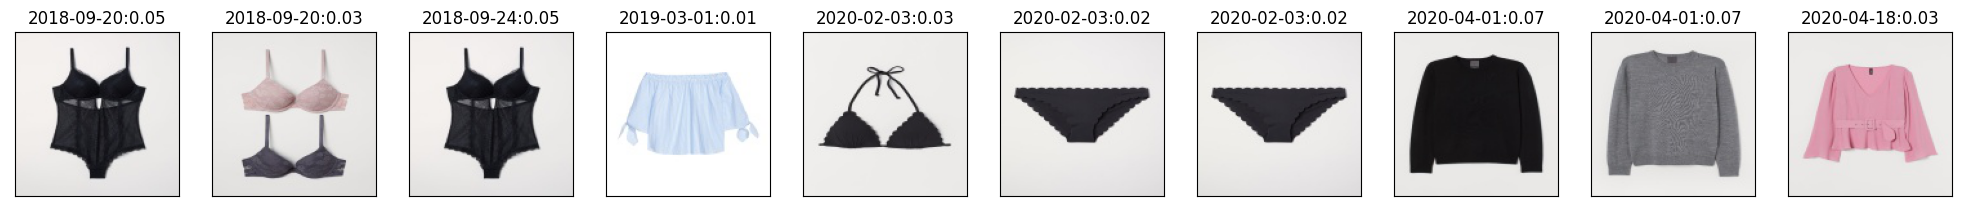

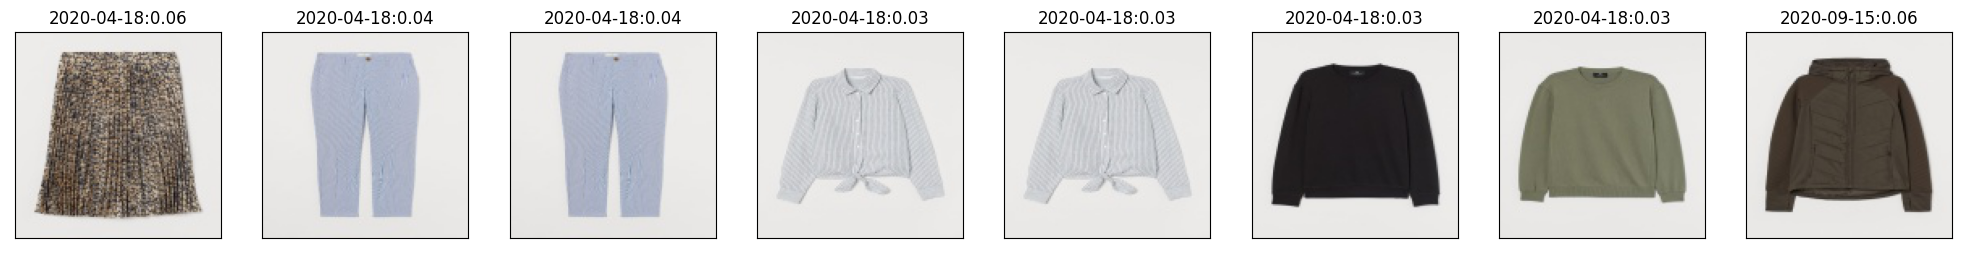

In [23]:
print_customer(train, articles, -6846340800584936)

## 交叉特征
### 以前是否买过同一个物品

In [24]:
train

,t_dat,customer_id,article_id,price,sales_channel_id,year,month,day
0,2018-09-20,-6846340800584936,663713001,0.050831,2,18,9,20
1,2018-09-20,-6846340800584936,541518023,0.030492,2,18,9,20
2,2018-09-24,-6846340800584936,663713001,0.050831,2,18,9,24
3,2019-03-01,-6846340800584936,578020002,0.013542,2,19,3,1
4,2020-02-03,-6846340800584936,723529001,0.025407,2,20,2,3
...,...,...,...,...,...,...,...,...
30451410,2020-09-22,-7687230332281787421,903647001,0.050831,2,20,9,22
30451411,2020-09-22,-7687230332281787421,903647001,0.050831,2,20,9,22
30451412,2020-09-22,5804240836826735721,913597001,0.042356,2,20,9,22
30451413,2020-09-22,5804240836826735721,903420001,0.033881,2,20,9,22


In [148]:
def is_purchased(df):
    if len(df)==1:
        df['is_purchased_before']=False
        return df
    df=df.sort_values('t_dat')
    last_row=None
    res=[]
    for i,(index, row) in enumerate(df.iterrows()):
        if last_row is not None and row['t_dat']!=last_row['t_dat']:
            res.append(T)
        else:
            res.append(False)
        last_row=row  
    df['is_purchased_before']
    return df

test=train[['t_dat','customer_id','article_id']].head(50).groupby(['customer_id','article_id']).apply(is_purchased)

        t_dat          customer_id  article_id
26 2018-09-23 -8334631767138808638   567618001
40 2018-09-27 -8334631767138808638   567618001
       t_dat       customer_id  article_id
5 2020-02-03 -6846340800584936   351484002
6 2020-02-03 -6846340800584936   351484002
       t_dat       customer_id  article_id
0 2018-09-20 -6846340800584936   663713001
2 2018-09-24 -6846340800584936   663713001
        t_dat       customer_id  article_id
11 2020-04-18 -6846340800584936   750424014
12 2020-04-18 -6846340800584936   750424014
        t_dat       customer_id  article_id
13 2020-04-18 -6846340800584936   870304002
14 2020-04-18 -6846340800584936   870304002


In [146]:
test

,t_dat,customer_id,article_id,is_purchased_before
0,2018-09-20,-6846340800584936,663713001,True
1,2018-09-20,-6846340800584936,541518023,False
2,2018-09-24,-6846340800584936,663713001,True
3,2019-03-01,-6846340800584936,578020002,False
4,2020-02-03,-6846340800584936,723529001,False
5,2020-02-03,-6846340800584936,351484002,False
6,2020-02-03,-6846340800584936,351484002,False
7,2020-04-01,-6846340800584936,727808001,False
8,2020-04-01,-6846340800584936,727808007,False
9,2020-04-18,-6846340800584936,858883002,False
